# Imports and functions

In [ ]:
import numpy as np
import optuna
import dask.array as da
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from functools import partial
from dask_ml.datasets import make_blobs as dask_make_blobs
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN, MiniBatchKMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.datasets import make_circles
from sklearn.decomposition import KernelPCA
from recursive_clustering.models.cohirf import ModularCoHiRF
from recursive_clustering.models.pseudo_kernel import PseudoKernelClustering
from recursive_clustering.models.lazy_minibatchkmeans import LazyMiniBatchKMeans
from recursive_clustering.models.kernel_kmeans import KernelKMeans
from recursive_clustering.metrics import adjusted_rand_score as dask_adjusted_rand_score
from recursive_clustering.experiment.spherical_clustering import generate_spherical_clusters, visualize_3d_data
from ml_experiments.tuners import OptunaTuner
from ml_experiments.utils import unflatten_dict, update_recursively
import pandas as pd

In [2]:
def training_fn(trial, model_cls, model_kwargs, features, true_labels):
    params = trial.params
    parsed_params = unflatten_dict(params)
    parsed_params = update_recursively(parsed_params, model_kwargs)
    model = model_cls(**parsed_params)
    labels = model.fit_predict(features)
    return adjusted_rand_score(true_labels, labels)

# Blobs

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

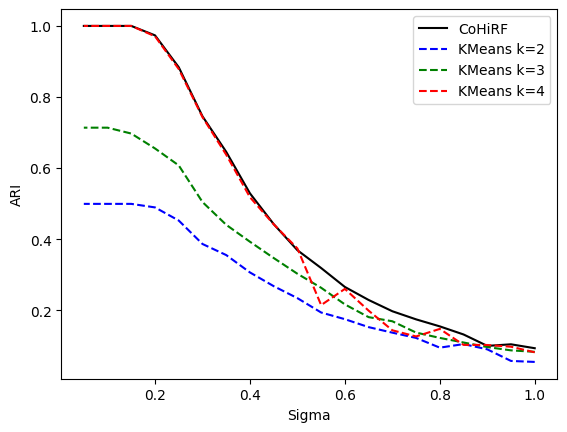

In [4]:
n_samples=1000
n_features=2
#centers = np.array([[0.5,0],[-0.5,0],[0,np.sqrt(3)/2]])
centers = np.array([[0.5,0.5],[-0.5,0.5],[-0.5,-0.5],[0.5,-0.5]])
components_size= 1
base_model = KMeans
base_model_kwargs = {'n_clusters': 2}
random_state=13
sigma_list = np.arange(1,0,-0.05)
baseline_1 = KMeans(n_clusters=2, random_state=random_state)
baseline_2 = KMeans(n_clusters=3, random_state=random_state)
baseline_3 = KMeans(n_clusters=4, random_state=random_state)
repetitiones = [3,4,5,6,7,8]
trials = 1

ari = np.empty((trials,len(sigma_list),len(repetitiones)))
baseline_1_ari = np.empty((trials,len(sigma_list)))
baseline_2_ari = np.empty((trials,len(sigma_list)))
baseline_3_ari = np.empty((trials,len(sigma_list)))
for t in tqdm(range(trials)):
    for cluster_std_, cluster_std  in tqdm(enumerate(sigma_list), total=len(sigma_list)):
        X, true_labels = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=cluster_std,
                                    random_state=random_state)
        X = StandardScaler().fit_transform(X)
        baseline_1.fit(X)
        baseline_2.fit(X)
        baseline_3.fit(X)
        baseline_1_ari[t,cluster_std_] = adjusted_rand_score(true_labels, baseline_1.labels_)
        baseline_2_ari[t,cluster_std_] = adjusted_rand_score(true_labels, baseline_2.labels_)
        baseline_3_ari[t,cluster_std_] = adjusted_rand_score(true_labels, baseline_3.labels_)
        for rep_, rep in enumerate(repetitiones):
            model = ModularCoHiRF(n_features=components_size, repetitions = rep, random_state=random_state, 
                                  base_model=base_model, base_model_kwargs=base_model_kwargs)
            model.fit(X)
            ari[t,cluster_std_, rep_] = adjusted_rand_score(true_labels, model.labels_)
            #print(f"For sigma={cluster_std}: CoHiRF score is {model.score(X)}")

plt.fill_between(sigma_list, np.quantile(ari.max(axis=2),0.1,axis=0), np.quantile(ari.max(axis=2),0.9,axis=0),color='gray', alpha = 0.1)
plt.plot(sigma_list,ari.max(axis=2).mean(axis=0),'k',label='CoHiRF')
plt.plot(sigma_list,baseline_1_ari.mean(axis=0),'b--',label='KMeans k=2')
plt.plot(sigma_list,baseline_2_ari.mean(axis=0),'g--',label='KMeans k=3')
plt.plot(sigma_list,baseline_3_ari.mean(axis=0),'r--',label='KMeans k=4')
plt.xlabel('Sigma')
plt.ylabel('ARI')
plt.legend()

# Cocentric Circles

Text(0.5, 1.0, 'Kernel CoHiRF : ARI 0.981')

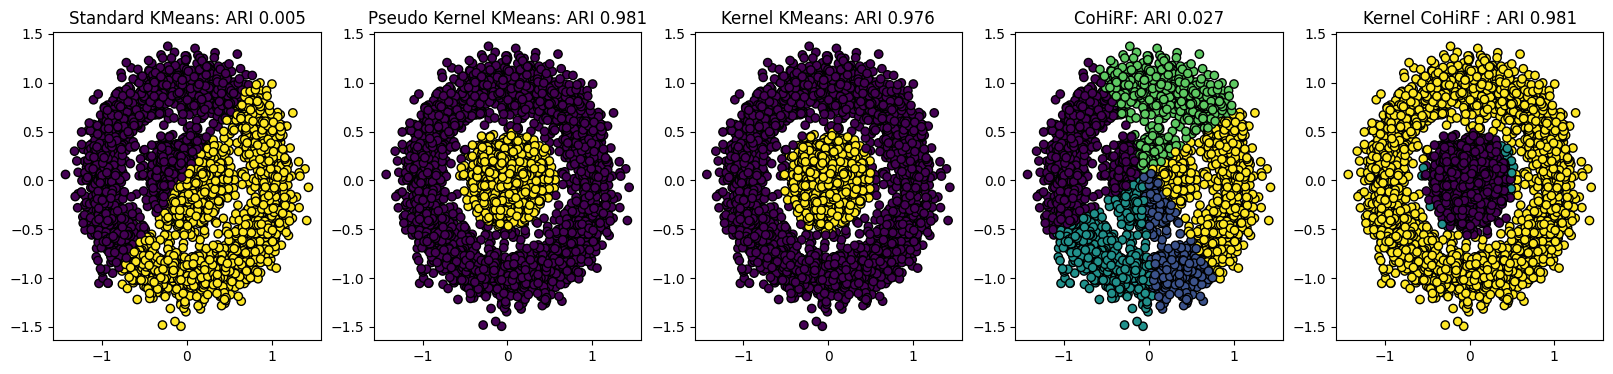

In [6]:
# dataset parameters
n_samples = 5000
factor = 0.15
noise = 0.15
random_state_dataset = 42
features, true_labels = make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=random_state_dataset)

random_state_model = 2000

# kmeans parameters
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=random_state_model)
kmeans_labels = kmeans.fit_predict(features)
ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)

# pseudo kernel kmeans parameters
n_clusters = 2
gamma = 3
n_rff = 500
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters, 'random_state': random_state_model}
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}

pseudo_kernel_kmeans = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
pseudo_kernel_kmeans_labels = pseudo_kernel_kmeans.fit_predict(features)
ari_pseudo_kernel_kmeans = adjusted_rand_score(true_labels, pseudo_kernel_kmeans_labels)

# kernel kmeans parameters
gamma = 3
n_clusters = 2
kernel = 'rbf'

kernel_kmeans = KernelKMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma, random_state=random_state_model)
kernel_kmeans_labels = kernel_kmeans.fit_predict(features)
ari_kernel_kmeans = adjusted_rand_score(true_labels, kernel_kmeans_labels)

# cohirf parameters
n_features = 'full'
repetitions = 3
n_clusters = 2
representative_method = 'closest_overall'
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters}
transform_method = 'random'
transform_kwargs = None

cohirf = ModularCoHiRF(n_features=n_features, repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        transform_method=transform_method, transform_kwargs=transform_kwargs, random_state=random_state_model)
cohirf_labels = cohirf.fit_predict(features)
ari_cohirf = adjusted_rand_score(true_labels, cohirf_labels)

# (pseudo) kernel cohirf parameters
n_features = 'full'
repetitions = 3
n_clusters = 2
representative_method = 'rbf'
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters}
gamma = 3
n_rff = 500
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}

cohirf_kernel = ModularCoHiRF(n_features=n_features, repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        transform_method=transform_method, transform_kwargs=transform_kwargs, random_state=random_state_model)
cohirf_kernel_labels = cohirf_kernel.fit_predict(features)
ari_cohirf_kernel = adjusted_rand_score(true_labels, cohirf_kernel_labels)


fig, axs = plt.subplots(1, 5, figsize=(5*4, 4))
axs[0].scatter(features[:, 0], features[:, 1], c=kmeans_labels, cmap='viridis', edgecolor='k')
axs[0].set_title(f'Standard KMeans: ARI {ari_kmeans:.3f}')

axs[1].scatter(features[:, 0], features[:, 1], c=pseudo_kernel_kmeans_labels, cmap='viridis', edgecolor='k')
axs[1].set_title(f'Pseudo Kernel KMeans: ARI {ari_pseudo_kernel_kmeans:.3f}')

axs[2].scatter(features[:, 0], features[:, 1], c=kernel_kmeans_labels, cmap='viridis', edgecolor='k')
axs[2].set_title(f'Kernel KMeans: ARI {ari_kernel_kmeans:.3f}')

axs[3].scatter(features[:, 0], features[:, 1], c=cohirf_labels, cmap='viridis', edgecolor='k')
axs[3].set_title(f'CoHiRF: ARI {ari_cohirf:.3f}')

axs[4].scatter(features[:, 0], features[:, 1], c=cohirf_kernel_labels, cmap='viridis', edgecolor='k')
axs[4].set_title(f'Kernel CoHiRF : ARI {ari_cohirf_kernel:.3f}')


# How much we can vary with seed

In [7]:
n_samples = 5000
factor = 0.15
noise = 0.15
random_state_dataset = 42
features, true_labels = make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=random_state_dataset)


## RFF Aproximation (seed dependant)

In [9]:
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_dataset)

kmeans_n_clusters = 2
n_rff = 500
repetitions = 3
representative_method = 'rbf'
gamma = 3
model_cls = ModularCoHiRF
search_space = {
    'random_state': optuna.distributions.IntDistribution(0, 100),
}
model_kwargs = {
    'n_features': 'full',
    'representative_method': representative_method,
    'repetitions': repetitions,
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': kmeans_n_clusters},
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': n_rff, 'gamma': gamma},
}
training_fn_cohirf = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
study = tuner.tune(training_fn=training_fn_cohirf, search_space=search_space, direction='maximize')

[I 2025-05-14 10:43:49,507] A new study created in memory with name: no-name-4b031444-23f2-41eb-8e3d-3d25b814bf52


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
min_value = study.trials_dataframe()['value'].min()
max_value = study.trials_dataframe()['value'].max()
print(f"Best trial value: {max_value}")
print(f"Worst trial value: {min_value}")
print(f"Mean trial value: {study.trials_dataframe()['value'].mean()}")
print(f"Std trial value: {study.trials_dataframe()['value'].std()}")

Best trial value: 0.9777228970485992
Worst trial value: 8.642894379849716e-06
Mean trial value: 0.7777632699491701
Std trial value: 0.39899209801205027


## Nystroem Aproximation

In [12]:
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_dataset)

kmeans_n_clusters = 2
n_rff = 500
repetitions = 3
representative_method = 'rbf'
gamma = 3
model_cls = ModularCoHiRF
search_space = {
    'random_state': optuna.distributions.IntDistribution(0, 100),
}
model_kwargs = {
    'n_features': 'full',
    'representative_method': representative_method,
    'repetitions': repetitions,
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': kmeans_n_clusters},
    'transform_method': Nystroem,
    'transform_kwargs': {'kernel': 'rbf', 'gamma': gamma, 'n_components': n_rff},
}
training_fn_cohirf = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
study = tuner.tune(training_fn=training_fn_cohirf, search_space=search_space, direction='maximize')

[I 2025-05-14 10:44:29,010] A new study created in memory with name: no-name-052d62b2-3fb3-4623-bfe9-c378703ba065


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

In [13]:
min_value = study.trials_dataframe()['value'].min()
max_value = study.trials_dataframe()['value'].max()
print(f"Best trial value: {max_value}")
print(f"Worst trial value: {min_value}")
print(f"Mean trial value: {study.trials_dataframe()['value'].mean()}")
print(f"Std trial value: {study.trials_dataframe()['value'].std()}")

Best trial value: 0.9761392275782216
Worst trial value: 0.9761392275782216
Mean trial value: 0.9761392275782217
Std trial value: 1.1390647892519134e-16


## True Kernel KMeans (not seed dependant)

In [14]:
n_samples = 5000
factor = 0.15
noise = 0.15
random_state_dataset = 42
features, true_labels = make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=random_state_dataset)

tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_dataset)

kmeans_n_clusters = 2
n_rff = 500
repetitions = 3
representative_method = 'rbf'
gamma = 3
model_cls = ModularCoHiRF
search_space = {
    'random_state': optuna.distributions.IntDistribution(0, 100),
}
model_kwargs = {
    'n_features': 'full',
    'representative_method': representative_method,
    'repetitions': repetitions,
    'base_model': KernelKMeans,
    'base_model_kwargs': {'n_clusters': kmeans_n_clusters, 'kernel': 'rbf', 'gamma': gamma},
}
training_fn_cohirf = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
study = tuner.tune(training_fn=training_fn_cohirf, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 10:45:19,306] A new study created in memory with name: no-name-838f4e15-4af2-4261-8dd1-d3c14faea96b


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
min_value = study.trials_dataframe()['value'].min()
max_value = study.trials_dataframe()['value'].max()
print(f"Best trial value: {max_value}")
print(f"Worst trial value: {min_value}")
print(f"Mean trial value: {study.trials_dataframe()['value'].mean()}")
print(f"Std trial value: {study.trials_dataframe()['value'].std()}")

Best trial value: 0.9761392275782216
Worst trial value: 0.9761392275782216
Mean trial value: 0.9761392275782217
Std trial value: 1.1390647892519134e-16


# Cocentric Spheres

## Base

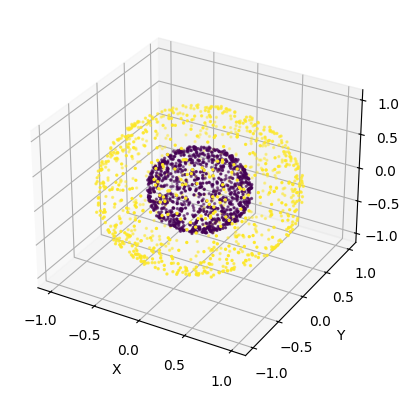

In [17]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01                 # Standard deviation for the radii
seed_dataset = 42
features, true_labels = generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000, seed=seed_dataset)

visualize_3d_data(features, true_labels)

In [18]:
# kmeans parameters
n_clusters = 2
random_state_model = 42000

kmeans = KMeans(n_clusters=n_clusters, random_state=random_state_model)
kmeans_labels = kmeans.fit_predict(features)
ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)


In [19]:
# pseudo kernel kmeans parameters
n_clusters = 2
gamma = 10
n_rff = 500
random_state_model = 42000
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters, 'random_state': random_state_model}
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff, 'random_state': random_state_model}
pseudo_kernel_kmeans = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
pseudo_kernel_kmeans_labels = pseudo_kernel_kmeans.fit_predict(features)
ari_pseudo_kernel_kmeans = adjusted_rand_score(true_labels, pseudo_kernel_kmeans_labels)


In [20]:
# kernel kmeans parameters
gamma = 10
n_clusters = 2
kernel = 'rbf'
random_state_model = 42000
kernel_kmeans = KernelKMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma, random_state=random_state_model)
kernel_kmeans_labels = kernel_kmeans.fit_predict(features)
ari_kernel_kmeans = adjusted_rand_score(true_labels, kernel_kmeans_labels)


In [21]:
# kernel cohirf parameters
random_state_model = 42000
n_features = 'full'
repetitions = 4
n_clusters = 2
representative_method = 'rbf'
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters}
gamma = 10
n_rff = 500
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}
cohirf_kernel = ModularCoHiRF(n_features=n_features, repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        transform_method=transform_method, transform_kwargs=transform_kwargs, random_state=random_state_model)
cohirf_kernel_labels = cohirf_kernel.fit_predict(features)
ari_cohirf_kernel = adjusted_rand_score(true_labels, cohirf_kernel_labels)

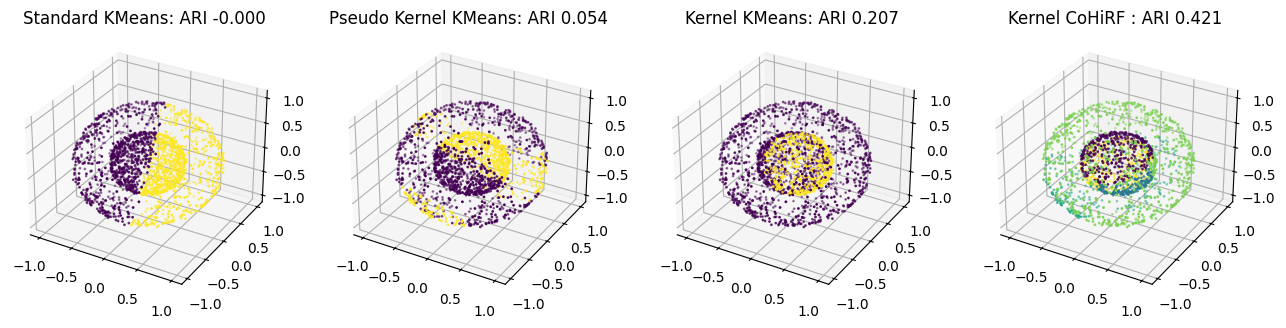

In [22]:

fig, axs = plt.subplots(1, 4, figsize=(4*4, 4), subplot_kw={'projection': '3d'})

axs[0].scatter(features[:, 0], features[:, 1], features[:, 2], c=kmeans_labels, cmap='viridis', s=1)
axs[0].set_title(f'Standard KMeans: ARI {ari_kmeans:.3f}')

axs[1].scatter(features[:, 0], features[:, 1], features[:, 2], c=pseudo_kernel_kmeans_labels, cmap='viridis', s=1)
axs[1].set_title(f'Pseudo Kernel KMeans: ARI {ari_pseudo_kernel_kmeans:.3f}')

axs[2].scatter(features[:, 0], features[:, 1], features[:, 2], c=kernel_kmeans_labels, cmap='viridis', s=1)
axs[2].set_title(f'Kernel KMeans: ARI {ari_kernel_kmeans:.3f}')

axs[3].scatter(features[:, 0], features[:, 1], features[:, 2], c=cohirf_kernel_labels, cmap='viridis', s=1)
axs[3].set_title(f'Kernel CoHiRF : ARI {ari_cohirf_kernel:.3f}')
plt.show()

## Optimization CoHiRF KernelKmeans 'full'

In [25]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 'full',
    'representative_method': 'rbf',
    'base_model': KMeans,
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

[I 2025-05-14 10:51:30,752] A new study created in memory with name: no-name-77bf6edd-2a3f-4f0d-8d0e-743d70791b60


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

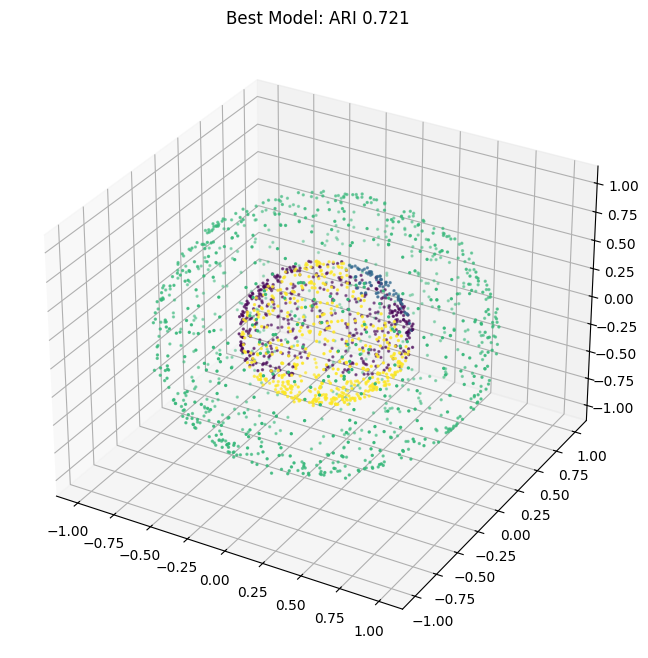

In [ ]:
best_params_cohirf = study.best_params
best_params_cohirf = unflatten_dict(best_params_cohirf)
best_params_cohirf = update_recursively(best_params_cohirf, model_kwargs)
best_model_cohirf = model_cls(**best_params_cohirf)
labels_cohirf = best_model_cohirf.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_cohirf):.3f}')
plt.show()

In [ ]:
best_params_cohirf

{'repetitions': 4,
 'sampling_kwargs': {'gamma': 8.189719601223231, 'n_components': 500},
 'base_model_kwargs': {'n_clusters': 4},
 'n_features': 'full',
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'sampling_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 42000}

## Optimization Kernel CoHiRF sampling

In [27]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 2,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 10:55:25,613] A new study created in memory with name: no-name-11479b6a-9ee5-4b81-81d0-a6d7ff1bbb23


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
study.best_value

0.2945858461185657

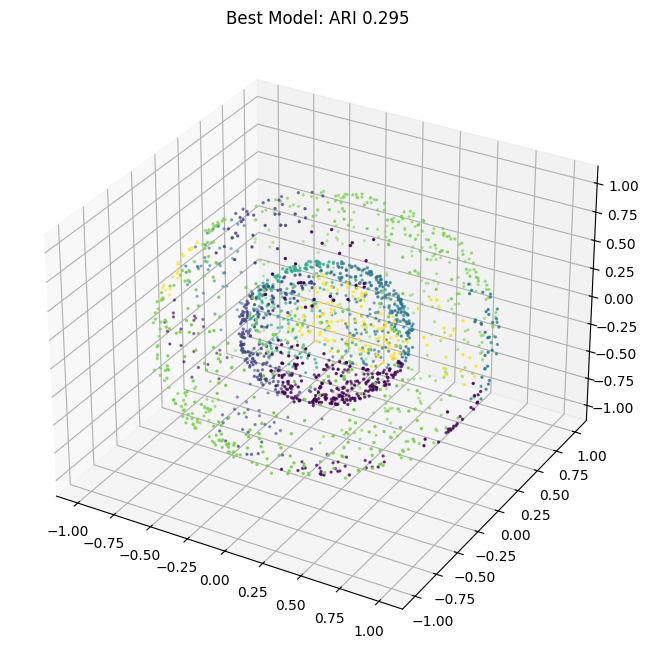

In [29]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

In [30]:
best_params_kernel_cohirf

{'repetitions': 2,
 'transform_kwargs': {'gamma': 17.314356850333887, 'n_components': 500},
 'base_model_kwargs': {'n_clusters': 4},
 'n_features': 2,
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'transform_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 42000}

## Optimization Kernel Kmeans

In [31]:
random_state_model = 42000
model_cls = KernelKMeans
search_space = {
    'gamma': optuna.distributions.FloatDistribution(0.1, 20),
}
model_kwargs = {
    'n_clusters': 2,
    'kernel': 'rbf',
    'random_state': random_state_model,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 10:56:54,882] A new study created in memory with name: no-name-968d66c6-90c2-47fc-845a-94f858de9f4d


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

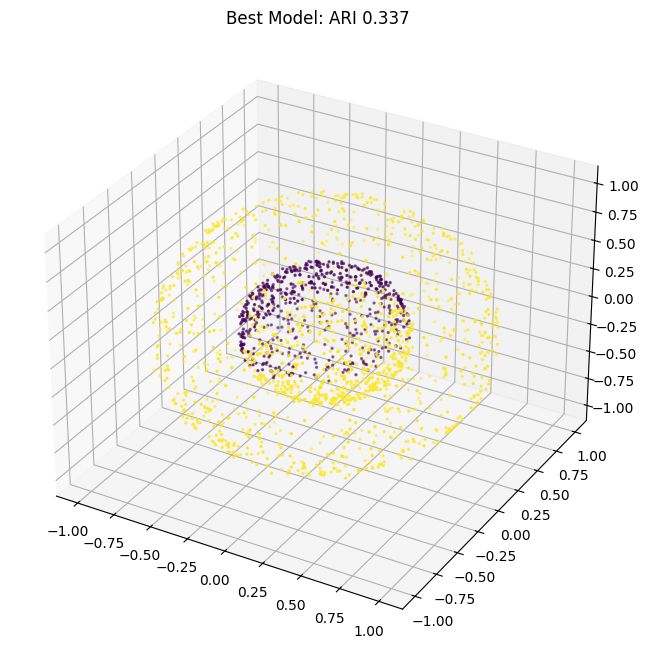

In [32]:
best_params_kernel_kmeans = study.best_params
best_params_kernel_kmeans = unflatten_dict(best_params_kernel_kmeans)
best_params_kernel_kmeans = update_recursively(best_params_kernel_kmeans, model_kwargs)
best_model_kernel_kmeans = model_cls(**best_params_kernel_kmeans)
labels_kernel_kmeans = best_model_kernel_kmeans.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_kmeans, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_kmeans):.3f}')
plt.show()

In [33]:
best_params_kernel_kmeans

{'gamma': 6.975480883180408,
 'n_clusters': 2,
 'kernel': 'rbf',
 'random_state': 42000}

## Optimization (Approx.) Kernel Kmeans

In [34]:
random_state_model = 42000
model_cls = PseudoKernelClustering
search_space = {
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2 ,'random_state': random_state_model},
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500, 'random_state': random_state_model},
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 10:57:34,525] A new study created in memory with name: no-name-8c828249-05cd-45bd-b458-01daee415063


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

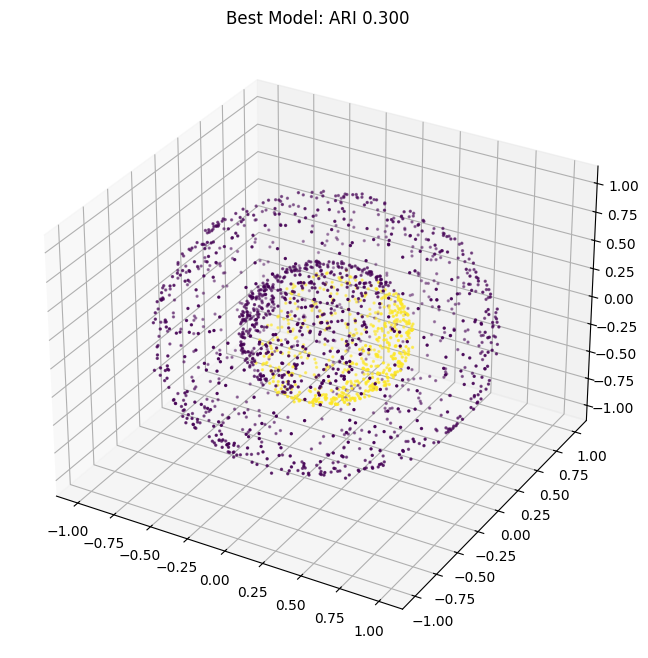

In [35]:
best_params_pseudo_kernel_kmeans = study.best_params
best_params_pseudo_kernel_kmeans = unflatten_dict(best_params_pseudo_kernel_kmeans)
best_params_pseudo_kernel_kmeans = update_recursively(best_params_pseudo_kernel_kmeans, model_kwargs)
best_model_pseudo_kernel_kmeans = model_cls(**best_params_pseudo_kernel_kmeans)
labels_pseudo_kernel_kmeans = best_model_pseudo_kernel_kmeans.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_pseudo_kernel_kmeans, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_pseudo_kernel_kmeans):.3f}')
plt.show()

In [36]:
best_params_pseudo_kernel_kmeans

{'transform_kwargs': {'gamma': 19.939919998571046,
  'n_components': 500,
  'random_state': 42000},
 'base_model': sklearn.cluster._kmeans.KMeans,
 'base_model_kwargs': {'n_clusters': 2, 'random_state': 42000},
 'transform_method': sklearn.kernel_approximation.RBFSampler}

# Cocentric Spheres + radius

## Base

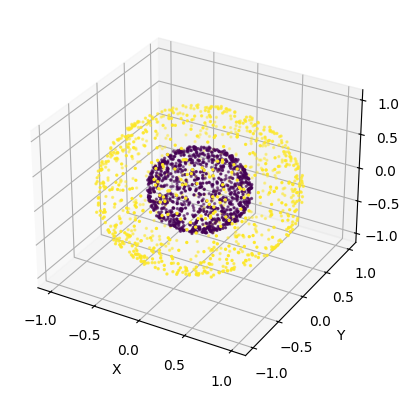

In [6]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01                 # Standard deviation for the radii
seed_dataset = 42
features, true_labels = generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000, seed=seed_dataset)

visualize_3d_data(features, true_labels)

features_extended = np.hstack((features,np.sum(features**2, axis=1, keepdims=True)))

In [7]:
# kmeans parameters
n_clusters = 2
random_state_model = 42

kmeans = KMeans(n_clusters=n_clusters, random_state=random_state_model)
kmeans_labels = kmeans.fit_predict(features_extended)
ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)

# pseudo kernel kmeans parameters
n_clusters = 2
gamma = 2
n_rff = 500
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters, 'random_state': random_state_model}
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}
pseudo_kernel_kmeans = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
pseudo_kernel_kmeans_labels = pseudo_kernel_kmeans.fit_predict(features_extended)
ari_pseudo_kernel_kmeans = adjusted_rand_score(true_labels, pseudo_kernel_kmeans_labels)

# kernel kmeans parameters
gamma = 2
n_clusters = 2
kernel = 'rbf'
kernel_kmeans = KernelKMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma, random_state=random_state_model)
kernel_kmeans_labels = kernel_kmeans.fit_predict(features_extended)
ari_kernel_kmeans = adjusted_rand_score(true_labels, kernel_kmeans_labels)

# kernel cohirf parameters
random_state_model = 13
n_features = 2
repetitions = 3
n_clusters = 2
representative_method = 'rbf'
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters}
gamma = 3
n_rff = 500
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}
cohirf_kernel = ModularCoHiRF(n_features=n_features, repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        transform_method=transform_method, transform_kwargs=transform_kwargs, random_state=random_state_model, sample_than_transform=True)
cohirf_kernel_labels = cohirf_kernel.fit_predict(features_extended)
ari_cohirf_kernel = adjusted_rand_score(true_labels, cohirf_kernel_labels)



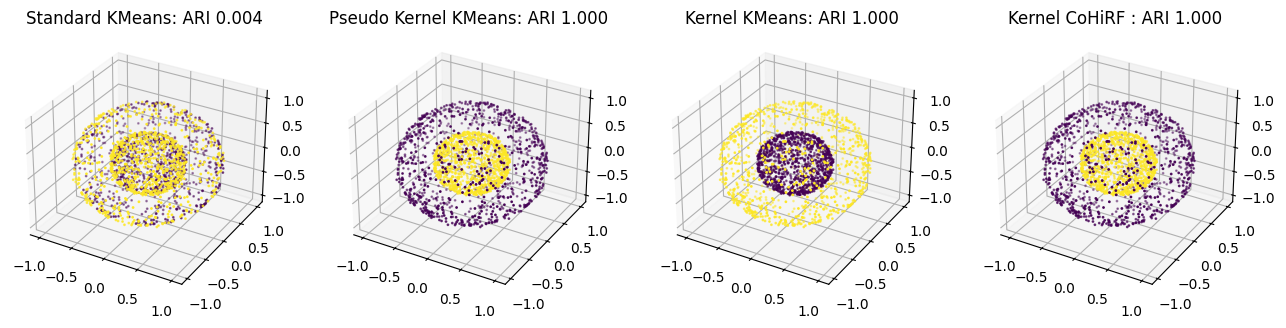

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(4*4, 4), subplot_kw={'projection': '3d'})

axs[0].scatter(features[:, 0], features[:, 1], features[:, 2], c=kmeans_labels, cmap='viridis', s=1)
axs[0].set_title(f'Standard KMeans: ARI {ari_kmeans:.3f}')

axs[1].scatter(features[:, 0], features[:, 1], features[:, 2], c=pseudo_kernel_kmeans_labels, cmap='viridis', s=1)
axs[1].set_title(f'Pseudo Kernel KMeans: ARI {ari_pseudo_kernel_kmeans:.3f}')

axs[2].scatter(features[:, 0], features[:, 1], features[:, 2], c=kernel_kmeans_labels, cmap='viridis', s=1)
axs[2].set_title(f'Kernel KMeans: ARI {ari_kernel_kmeans:.3f}')

axs[3].scatter(features[:, 0], features[:, 1], features[:, 2], c=cohirf_kernel_labels, cmap='viridis', s=1)
axs[3].set_title(f'Kernel CoHiRF : ARI {ari_cohirf_kernel:.3f}')
plt.show()

## KPCA Kmeans

In [7]:
n_clusters = 2
kernel = 'rbf'
gamma = 3
n_components = 3
random_state_model = 42
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters, 'random_state': random_state_model}
transform_method = KernelPCA
transform_kwargs = dict(kernel=kernel, n_components=n_components, gamma=gamma)
model = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
labels = model.fit_predict(features_extended)
ari = adjusted_rand_score(true_labels, labels)

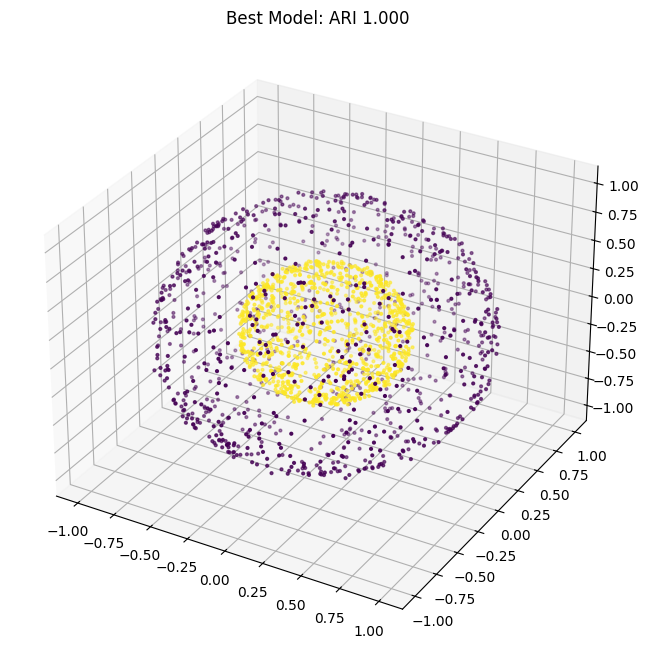

In [8]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=4)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

## HDBSCAN

In [9]:
model = HDBSCAN(min_cluster_size=5)
labels = model.fit_predict(features_extended)
ari = adjusted_rand_score(true_labels, labels)

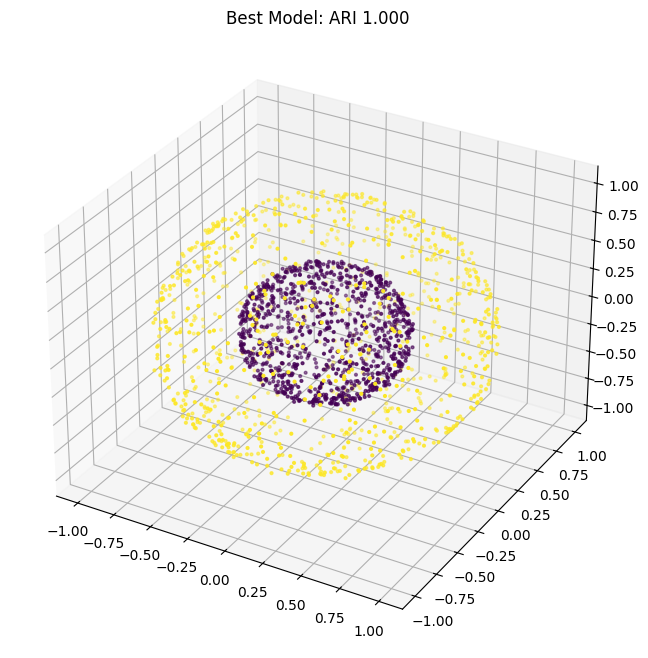

In [11]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=4)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

## DBSCAN

In [12]:
model = DBSCAN(eps=0.5, min_samples=5)
labels = model.fit_predict(features_extended)
ari = adjusted_rand_score(true_labels, labels)

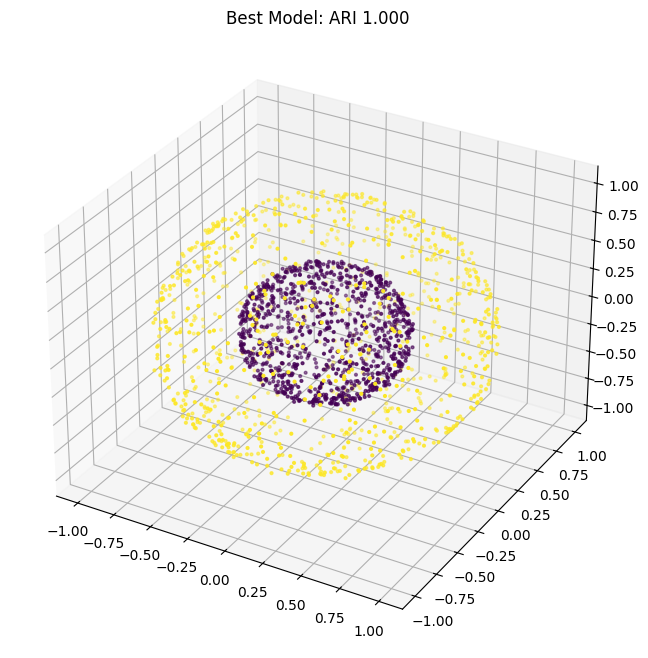

In [14]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=4)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

## Optimization kernel cohirf

### Seed 13

In [46]:
random_state_model = 13
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 2,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 10:57:42,331] A new study created in memory with name: no-name-412a9a48-531d-4748-ac33-622d4afd9e33


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [47]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.094396 2025-05-14 10:57:42.342843 2025-05-14 10:57:45.044487   
1        1  0.047185 2025-05-14 10:57:45.045174 2025-05-14 10:57:48.248471   
2        2  0.058501 2025-05-14 10:57:48.249310 2025-05-14 10:57:49.935946   
3        3  0.200880 2025-05-14 10:57:49.936644 2025-05-14 10:57:51.325865   
4        4  0.369779 2025-05-14 10:57:51.326753 2025-05-14 10:57:51.803929   
5        5  0.132976 2025-05-14 10:57:51.804609 2025-05-14 10:57:53.706978   
6        6  0.121154 2025-05-14 10:57:53.707640 2025-05-14 10:57:54.120762   
7        7  0.435936 2025-05-14 10:57:54.121496 2025-05-14 10:57:54.786932   
8        8  0.436176 2025-05-14 10:57:54.787817 2025-05-14 10:57:55.151121   
9        9  0.053767 2025-05-14 10:57:55.151788 2025-05-14 10:57:56.662893   
10      10  0.457522 2025-05-14 10:57:56.663698 2025-05-14 10:57:57.066596   
11      11  0.729591 2025-05-14 10:57:57.067477 2025-05-14 10:57:57.619563   
12      12  0.813899 2025-05-14 10:57:57.620299 2025-05-14 10:57:58.111445   
13      13  0.771764 2025-05-14 10:57:58.115113 2025-05-14 10:57:58.855282   
14      14  0.562865 2025-05-14 10:57:58.856029 2025-05-14 10:57:59.715739   
15      15  0.430049 2025-05-14 10:57:59.721541 2025-05-14 10:58:00.417871   
16      16  1.000000 2025-05-14 10:58:00.419065 2025-05-14 10:58:00.626235   
17      17  1.000000 2025-05-14 10:58:00.630273 2025-05-14 10:58:01.045468   
18      18  0.381976 2025-05-14 10:58:01.047751 2025-05-14 10:58:01.445992   
19      19  1.000000 2025-05-14 10:58:01.446713 2025-05-14 10:58:01.829358   

                 duration  params_base_model_kwargs/n_clusters  \
0  0 days 00:00:02.701644                                    9   
1  0 days 00:00:03.203297                                    6   
2  0 days 00:00:01.686636                                    7   
3  0 days 00:00:01.389221                                    4   
4  0 days 00:00:00.477176                                    5   
5  0 days 00:00:01.902369                                    5   
6  0 days 00:00:00.413122                                   10   
7  0 days 00:00:00.665436                                   10   
8  0 days 00:00:00.363304                                    7   
9  0 days 00:00:01.511105                                    8   
10 0 days 00:00:00.402898                                    4   
11 0 days 00:00:00.552086                                    5   
12 0 days 00:00:00.491146                                    3   
13 0 days 00:00:00.740169                                    2   
14 0 days 00:00:00.859710                                    3   
15 0 days 00:00:00.696330                                    2   
16 0 days 00:00:00.207170                                    2   
17 0 days 00:00:00.415195                                    2   
18 0 days 00:00:00.398241                                    4   
19 0 days 00:00:00.382645                                    2   

    params_repetitions  params_transform_kwargs/gamma  user_attrs_result  \
0                    8                       7.202482           0.094396   
1                   10                      29.180773           0.047185   
2                    7                      23.288243           0.058501   
3                    8                       1.147592           0.200880   
4                    2                      25.726122           0.369779   
5                    8                       7.762770           0.132976   
6                    2                      10.814180           0.121154   
7                    3                       9.649802           0.435936   
8                    2                       2.046028           0.436176   
9                    9                       0.360600           0.053767   
10                   2                       5.588019           0.457522   
11                   3                       3.562946           0.

In [48]:
study.best_value

1.0

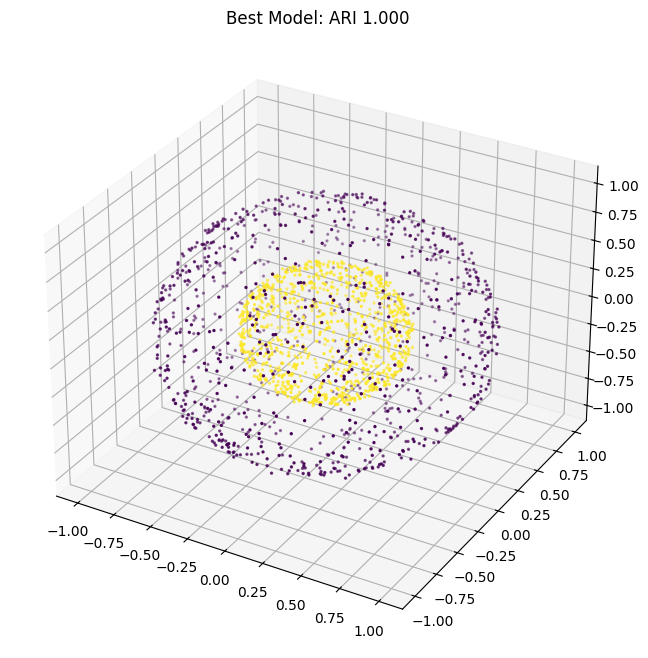

In [49]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

In [50]:
best_params_kernel_cohirf

{'repetitions': 2,
 'transform_kwargs': {'gamma': 3.130760691303247, 'n_components': 500},
 'base_model_kwargs': {'n_clusters': 2},
 'n_features': 2,
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'transform_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 13,
 'sample_than_transform': True}

### Seed 42000

In [51]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 2,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 10:58:02,881] A new study created in memory with name: no-name-8b864fbb-2686-42a1-bbeb-9b9eac07ca23


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [52]:
study.best_value

0.6510809548976532

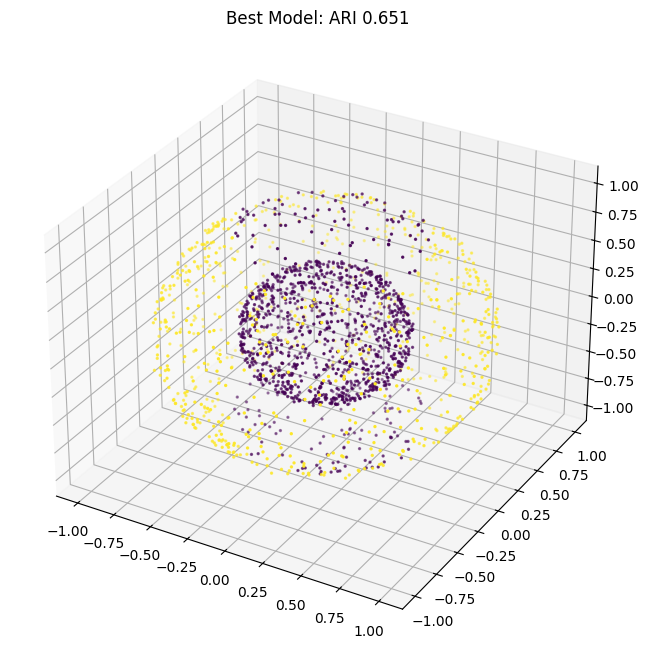

In [53]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

### Seed 13 transform then sample

In [54]:
random_state_model = 13
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 0.5,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': False,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 10:58:30,118] A new study created in memory with name: no-name-3ad22b32-4583-408e-afea-688f8e075ea9


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [55]:
study.best_value

1.0

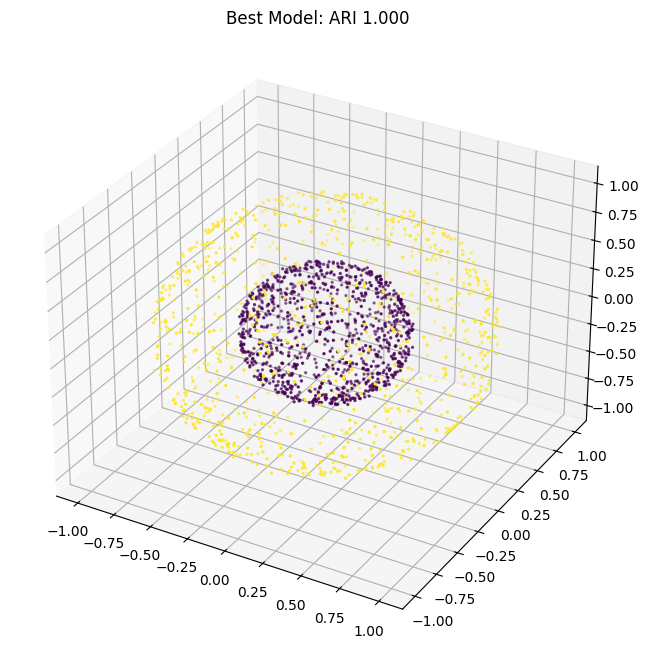

In [56]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

In [57]:
best_params_kernel_cohirf

{'repetitions': 5,
 'transform_kwargs': {'gamma': 2.237489570922963, 'n_components': 500},
 'base_model_kwargs': {'n_clusters': 2},
 'n_features': 0.5,
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'transform_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 13,
 'sample_than_transform': False}

### Seed 13 transform once then sample

In [58]:
random_state_model = 13
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 0.5,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': False,
    'transform_once_per_iteration': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 10:58:54,469] A new study created in memory with name: no-name-03c8ae2b-5325-4ae6-a285-fcee905121fc


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [59]:
study.best_value

1.0

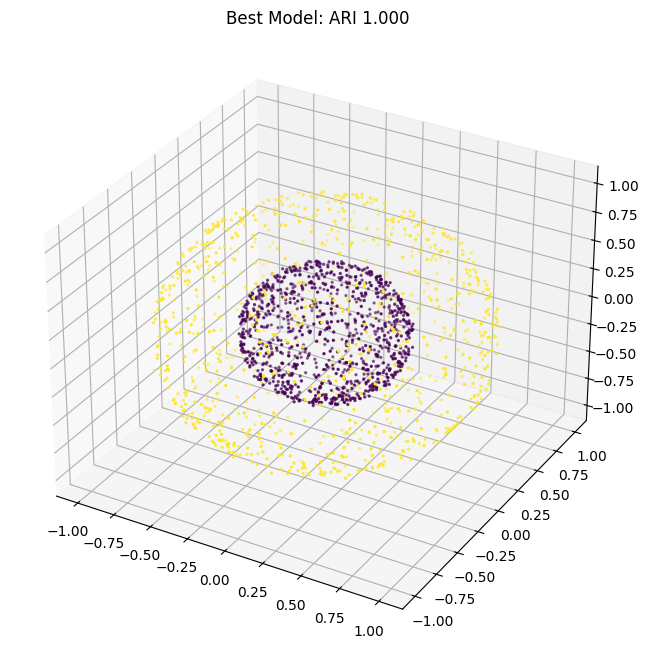

In [60]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

### Seed 42000 transform then sample

In [61]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 0.5,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': False,
    'transform_once_per_iteration': False,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 10:59:15,591] A new study created in memory with name: no-name-4a835d15-5eb1-4864-87de-4714f4b0586a


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [62]:
study.best_value

0.7683532917219453

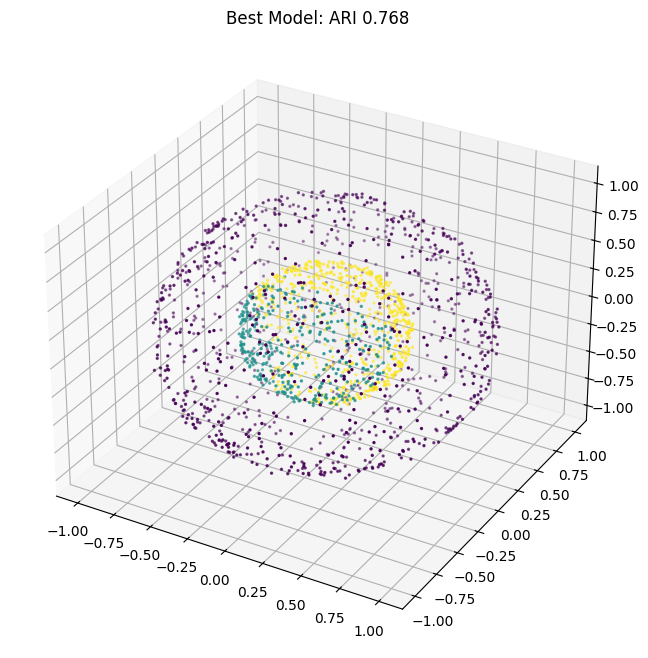

In [63]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf, max_iter=8)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

### Seed 42000 transform once then sample

In [64]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 0.5,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': False,
    'transform_once_per_iteration': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 10:59:41,978] A new study created in memory with name: no-name-edce4b99-46ce-4259-8980-19cea4699cfe


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [65]:
study.best_value

0.603117717468637

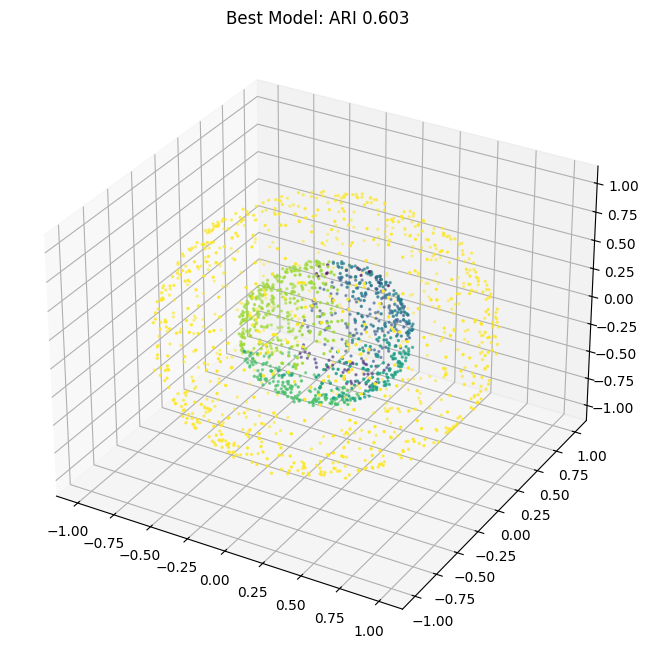

In [66]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

### Seed 42000 fixed number of clusters for KMeans

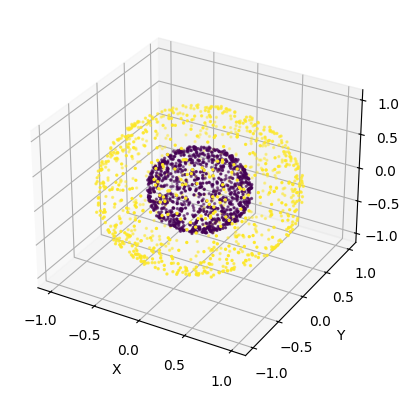

In [67]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01                 # Standard deviation for the radii
seed_dataset = 42
features, true_labels = generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000, seed=seed_dataset)

visualize_3d_data(features, true_labels)

features_extended = np.hstack((features,np.sum(features**2, axis=1, keepdims=True)))

In [68]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'n_features': 2,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2},
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 11:00:03,794] A new study created in memory with name: no-name-b35edf79-80a4-4817-ad4f-537069991110


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [69]:
study.best_value

1.0

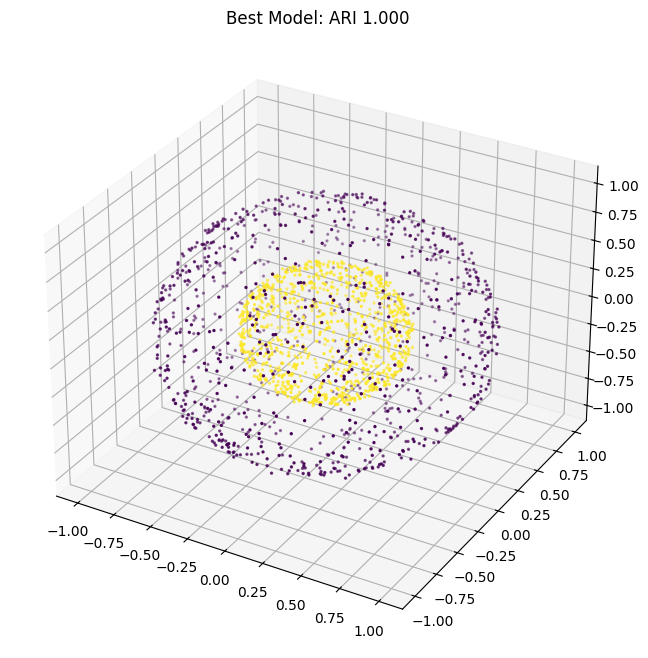

In [70]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

In [71]:
best_params_kernel_cohirf

{'repetitions': 4,
 'transform_kwargs': {'gamma': 9.79200930288217, 'n_components': 500},
 'n_features': 2,
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'base_model_kwargs': {'n_clusters': 2},
 'transform_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 42000,
 'sample_than_transform': True}

## Optimization Kernel Kmeans

In [72]:
random_state_model = 13
model_cls = KernelKMeans
search_space = {
    'gamma': optuna.distributions.FloatDistribution(0.1, 20),
}
model_kwargs = {
    'n_clusters': 2,
    'kernel': 'rbf',
    'random_state': random_state_model,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 11:00:23,306] A new study created in memory with name: no-name-003c98d1-644a-4406-9cb7-2cef0995b762


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

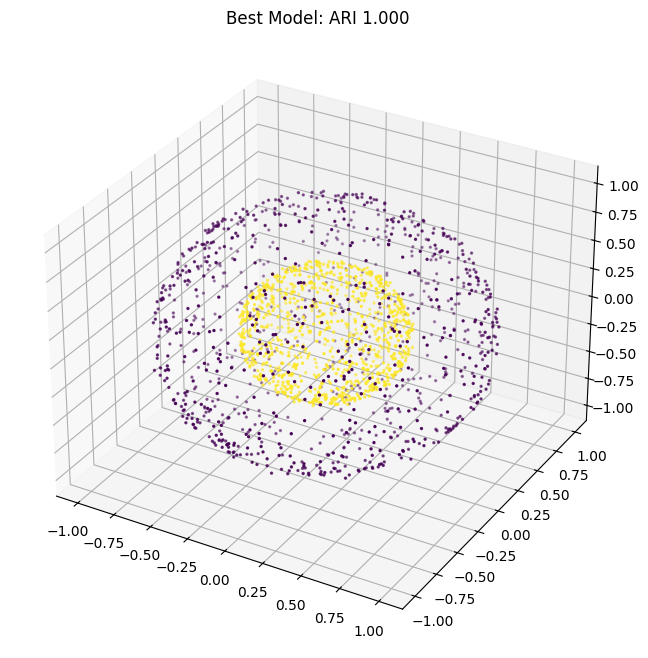

In [73]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

In [74]:
best_params

{'gamma': 4.028263121618731,
 'n_clusters': 2,
 'kernel': 'rbf',
 'random_state': 13}

## Optimization (Approx.) Kernel Kmeans

In [75]:
random_state_model = 42000
model_cls = PseudoKernelClustering
search_space = {
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2 ,'random_state': random_state_model},
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500, 'random_state': random_state_model},
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 11:01:07,455] A new study created in memory with name: no-name-4a523266-9e31-439b-b1c2-28a12564bd40


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

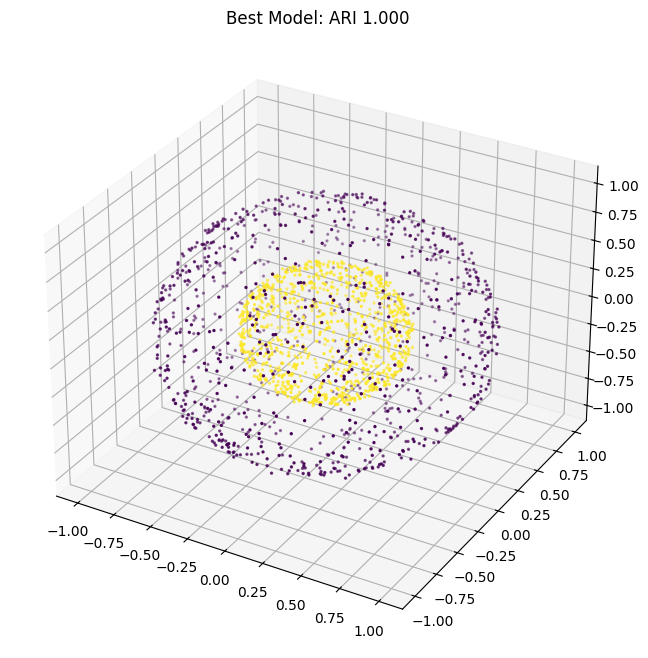

In [76]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

In [77]:
best_params

{'transform_kwargs': {'gamma': 2.435332138564481,
  'n_components': 500,
  'random_state': 42000},
 'base_model': sklearn.cluster._kmeans.KMeans,
 'base_model_kwargs': {'n_clusters': 2, 'random_state': 42000},
 'transform_method': sklearn.kernel_approximation.RBFSampler}

## Optimization kernel cohirf 1 iteration|

In [9]:
seeds = [42, 13, 42000, 894231, 123189, 123198749, 9845, 79841, 365478, 5678946]
results = {}
for seed in seeds:
    random_state_model = seed
    model_cls = ModularCoHiRF
    search_space = {
        "repetitions": optuna.distributions.IntDistribution(2, 10),
        "transform_kwargs": {
            "gamma": optuna.distributions.FloatDistribution(0.1, 30),
        },
    }
    model_kwargs = {
        "n_features": 2,
        "representative_method": "rbf",
        "base_model": KMeans,
        "base_model_kwargs": {
            "n_clusters": 2,
        },
        "transform_method": RBFSampler,
        "transform_kwargs": {"n_components": 500},
        "random_state": random_state_model,
        "sample_than_transform": True,
        # "max_iter": 1,
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended, true_labels=true_labels
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_params = unflatten_dict(best_params)
    best_value = study.best_value
    results[seed] = dict(
        best_params=best_params,
        best_value=best_value,
        study=study,
    )

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:26:55,761] A new study created in memory with name: no-name-1650d27b-269e-41c5-a514-41a7f36af4f4


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:27:12,952] A new study created in memory with name: no-name-2495957e-9723-42bc-a63a-cae865947482


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:27:29,357] A new study created in memory with name: no-name-e693bda4-7667-4de9-acbd-a083fb20f845


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:27:46,823] A new study created in memory with name: no-name-a0257130-acdc-405f-af12-2cc549f7c605


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:28:09,454] A new study created in memory with name: no-name-f9f18528-d707-4354-b313-c56c1fcee528


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:28:28,959] A new study created in memory with name: no-name-a3093996-f157-4641-8b84-63ffe1e529fb


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:28:48,522] A new study created in memory with name: no-name-a3804358-b9d2-4dc0-946d-737f5081faba


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:29:10,173] A new study created in memory with name: no-name-b0fcb28a-b0fe-4585-9931-fcb08c0c9f8e


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:29:25,798] A new study created in memory with name: no-name-f92742fa-ce62-41a7-869c-59503bf6f8fa


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:29:44,725] A new study created in memory with name: no-name-d80814bf-864c-4363-a180-323bcb355a81


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame.from_dict(results, orient='index')
df = df.drop(columns=['study'])
df = pd.concat([df.drop('best_params', axis=1), df['best_params'].apply(pd.Series)], axis=1)
max_best_value = df['best_value'].max()
min_best_value = df['best_value'].min()
std_best_value = df['best_value'].std()
display(df)
print(f'Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}')

best_value  repetitions               transform_kwargs
42           0.903611            5   {'gamma': 8.807751291921452}
13           1.000000            2  {'gamma': 25.726122183357248}
42000        0.663972            4  {'gamma': 12.642021919661497}
894231       0.528092            6  {'gamma': 11.420938682394691}
123189       1.000000            2  {'gamma': 3.7176683897002984}
123198749    0.780164            2  {'gamma': 29.350149054640823}
9845         0.764739            4  {'gamma': 11.511549377981494}
79841        1.000000            2   {'gamma': 6.064746017081428}
365478       0.749844            4   {'gamma': 10.11840826155265}
5678946      0.667159            3   {'gamma': 27.46288279636691}

Max Best Value: 1.0, Min Best Value: 0.5280921061714371, Std Best Value: 0.16487047861269233


In [13]:
seeds = [42, 13, 42000, 894231, 123189, 123198749, 9845, 79841, 365478, 5678946]
results = {}
for seed in seeds:
    random_state_model = seed
    model_cls = ModularCoHiRF
    search_space = {
        "repetitions": optuna.distributions.IntDistribution(2, 10),
        "transform_kwargs": {
            "gamma": optuna.distributions.FloatDistribution(0.1, 30),
        },
    }
    model_kwargs = {
        "n_features": 2,
        "representative_method": "rbf",
        "base_model": KMeans,
        "base_model_kwargs": {
            "n_clusters": 2,
        },
        "transform_method": RBFSampler,
        "transform_kwargs": {"n_components": 500},
        "random_state": random_state_model,
        "sample_than_transform": True,
        "max_iter": 1,
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended, true_labels=true_labels
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_params = unflatten_dict(best_params)
    best_value = study.best_value
    results[seed] = dict(
        best_params=best_params,
        best_value=best_value,
        study=study,
    )
    best_params = update_recursively(best_params, model_kwargs)
    best_params['max_iter'] = 100
    best_model = model_cls(**best_params)
    labels = best_model.fit_predict(features_extended)
    ari_final = adjusted_rand_score(true_labels, labels)
    results[seed]['ari_final'] = ari_final

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:33:09,631] A new study created in memory with name: no-name-0a985883-967b-4d72-9331-62b76223c510


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:33:23,908] A new study created in memory with name: no-name-678853b7-7ab9-4d29-9a28-4320ee43a254


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:33:42,039] A new study created in memory with name: no-name-0c6df44e-fee3-4c76-a9dc-8094c83ed28d


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:33:58,466] A new study created in memory with name: no-name-044138cf-1427-4f6d-a18c-28f9466aec14


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:34:18,514] A new study created in memory with name: no-name-0dc6e07e-2c56-4470-bf88-89a79c8d2436


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:34:39,150] A new study created in memory with name: no-name-6dc3125b-40fc-46cf-a7ef-7cabfd862a60


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:34:54,224] A new study created in memory with name: no-name-4b5f3663-366c-4f3b-80f0-48b2170db70d


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:35:11,268] A new study created in memory with name: no-name-4b904907-d6ff-4c1e-b22e-b8f96ea04a88


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:35:26,197] A new study created in memory with name: no-name-183fa1f8-52ba-4d2c-9c23-29d455809002


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:35:41,909] A new study created in memory with name: no-name-3f8365f8-b986-4fc1-83e4-9991dc3716e2


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
df = pd.DataFrame.from_dict(results, orient="index")
df = df.drop(columns=["study"])
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

best_value  ari_final  repetitions  \
42           0.682304   0.375503            2   
13           1.000000   1.000000            4   
42000        0.487944   0.619643            4   
894231       0.324902   0.211805            6   
123189       0.632557   1.000000            4   
123198749    0.677483   0.677483            4   
9845         0.641695   0.641695            2   
79841        0.678232   0.678232            2   
365478       0.566289   0.177810            3   
5678946      0.669036   0.008015            2   

                                            transform_kwargs  n_features  \
42         {'gamma': 24.203763282737782, 'n_components': ...           2   
13         {'gamma': 2.4221976108705743, 'n_components': ...           2   
42000      {'gamma': 16.52515694552359, 'n_components': 500}           2   
894231     {'gamma': 25.198324084716546, 'n_components': ...           2   
123189     {'gamma': 13.717134406087583, 'n_components': ...           2   
123198749  {'gamma': 15.391434458224294, 'n_components': ...           2   
9845       {'gamma': 11.64801248635772, 'n_components': 500}           2   
79841      {'gamma': 29.002713995048317, 'n_components': ...           2   
365478     {'gamma': 6.689299467123862, 'n_components': 500}           2   
5678946    {'gamma': 20.604848188075756, 'n_components': ...           2   

          representative_method                                base_model  \
42                          rbf  <class 'sklearn.cluster._kmeans.KMeans'>   
13                          rbf  <class 'sklearn.cluster._kmeans.KMeans'>   
42000                       rbf  <class 'sklearn.cluster._kmeans.KMeans'>   
894231                      rbf  <class 'sklearn.cluster._kmeans.KMeans'>   
123189                      rbf  <class 'sklearn.cluster._kmeans.KMeans'>   
123198749                   rbf  <class 'sklearn.cluster._kmeans.KMeans'>   
9845                        rbf  <class 'sklearn.cluster._kmeans.KMeans'>   
79841                       rbf  <class 'sklearn.cluster._kmeans.KMeans'>   
365478                      rbf  <class 'sklearn.cluster._kmeans.KMeans'>   
5678946                     rbf  <class 'sklearn.cluster._kmeans.KMeans'>   

           base_model_kwargs  \
42         {'n_clusters': 2}   
13         {'n_clusters': 2}   
42000      {'n_clusters': 2}   
894231     {'n_clusters': 2}   
123189     {'n_clusters': 2}   
123198749  {'n_clusters': 2}   
9845       {'n_clusters': 2}   
79841      {'n_clusters': 2}   
365478     {'n_clusters': 2}   
5678946    {'n_clusters': 2}   

                                            transform_method  random_state  \
42         <class 'sklearn.kernel_approximation.RBFSampler'>            42   
13         <class 'sklearn.kernel_approximation.RBFSampler'>            13   
42000      <class 'sklearn.kernel_approximation.RBFSampler'>         42000   
894231     <class 'sklearn.kernel_approximation.RBFSampler'>        894231   
123189     <class 'sklearn.kernel_approximation.RBFSampler'>        123189   
123198749  <class 'sklearn.kernel_approximation.RBFSampler'>     123198749   
9845       <class 'sklearn.kernel_approximation.RBFSampler'>          9845   
79841      <class 'sklearn.kernel_approximation.RBFSampler'>         79841   
365478     <class 'sklearn.kernel_approximation.RBFSampler'>        365478   
5678946    <class 'sklearn.kernel_approximation.RBFSampler'>       5678946   

           sample_than_transform  max_iter  
42                          True       100  
13                          True       100  
42000                       True       100  
894231                      True       100  
123189                      True       100  
123198749                   True       100  
9845                        True       100  
79841                       True       100  
365478                      True       100  
5678946                     True       100

Max Best Value: 1.0, Min Best Value: 0.32490248104121205, Std Best Value: 0.1708937150667142


In [43]:
seeds = [42, 13, 42000, 894231, 123189, 123198749, 9845, 79841, 365478, 5678946]
results = {}
for seed in seeds:
    random_state_model = seed
    model_cls = ModularCoHiRF
    search_space = {
        "transform_kwargs": {
            "gamma": optuna.distributions.FloatDistribution(0.1, 30),
        },
    }
    model_kwargs = {
        "n_features": 2,
        "repetitions": 2,
        "representative_method": "rbf",
        "base_model": KMeans,
        "base_model_kwargs": {
            "n_clusters": 2,
        },
        "transform_method": RBFSampler,
        "transform_kwargs": {"n_components": 500},
        "random_state": random_state_model,
        "sample_than_transform": True,
        # "max_iter": 1,
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended, true_labels=true_labels
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_params = unflatten_dict(best_params)
    best_value = study.best_value
    results[seed] = dict(
        best_params=best_params,
        best_value=best_value,
        study=study,
    )

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 12:27:52,224] A new study created in memory with name: no-name-6f5c418e-d24d-496d-a9c5-4a4da7134e9f


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 12:28:01,498] A new study created in memory with name: no-name-2bd493d9-5e17-47cc-9f1f-5febe1a44d0b


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 12:28:09,358] A new study created in memory with name: no-name-3eafb839-d35e-4ced-bc9d-e354334f03ff


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 12:28:16,394] A new study created in memory with name: no-name-c9b2b433-1835-4d1e-84ee-6743d98c5fcf


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 12:28:24,306] A new study created in memory with name: no-name-3b482c5b-5747-4bcd-9b70-c0f467e0f8f1


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 12:28:33,129] A new study created in memory with name: no-name-ad3b0f78-2766-495a-9a07-c04faaa61543


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 12:28:40,314] A new study created in memory with name: no-name-8166c4fb-bc5f-4066-b499-15f30f2f67ec


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 12:28:48,556] A new study created in memory with name: no-name-f88b25ed-5f68-447a-9aaa-6cfd96e45606


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 12:28:57,082] A new study created in memory with name: no-name-7a555a0b-d5f9-40b2-abd3-b04cf854ecc1


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 12:29:04,964] A new study created in memory with name: no-name-e89e6058-e6d0-4f78-b172-3976a8613b53


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [44]:
df = pd.DataFrame.from_dict(results, orient="index")
df = df.drop(columns=["study"])
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

best_value               transform_kwargs
42           0.505376   {'gamma': 9.409225510954986}
13           1.000000  {'gamma': 23.353302076157224}
42000        0.651081    {'gamma': 22.5398817564965}
894231       0.218375   {'gamma': 9.613916575633079}
123189       1.000000   {'gamma': 3.345156734583235}
123198749    1.000000   {'gamma': 11.69159932356492}
9845         0.501931   {'gamma': 5.539723669994514}
79841        1.000000   {'gamma': 9.615541587715786}
365478       0.894342   {'gamma': 7.475002496472865}
5678946      0.918056  {'gamma': 22.716275898461195}

Max Best Value: 1.0, Min Best Value: 0.2183752918899798, Std Best Value: 0.2807307734932246


In [7]:
seeds = [42, 13, 42000, 894231, 123189, 123198749, 9845, 79841, 365478, 5678946]
results = {}
for seed in seeds:
    random_state_model = seed
    model_cls = ModularCoHiRF
    search_space = {
        "repetitions": optuna.distributions.IntDistribution(2, 10),
        "transform_kwargs": {
            "gamma": optuna.distributions.FloatDistribution(0.1, 30),
        },
    }
    model_kwargs = {
        "n_features": 2,
        "representative_method": "rbf",
        "base_model": KMeans,
        "base_model_kwargs": {
            "n_clusters": 2,
        },
        "transform_method": Nystroem,
        "transform_kwargs": {"n_components": 500},
        "random_state": random_state_model,
        "sample_than_transform": True,
        # "max_iter": 1,
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended, true_labels=true_labels
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_params = unflatten_dict(best_params)
    best_value = study.best_value
    results[seed] = dict(
        best_params=best_params,
        best_value=best_value,
        study=study,
    )

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:14:32,123] A new study created in memory with name: no-name-dd86ff4e-417a-4e7c-a55e-88a7fe460e90


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

In [8]:
df = pd.DataFrame.from_dict(results, orient="index")
df = df.drop(columns=["study"])
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

best_value  repetitions               transform_kwargs
42           0.754203            2  {'gamma': 25.998666758670563}
13           1.000000            2   {'gamma': 9.023639179586462}
42000        0.750040            5  {'gamma': 4.0544854770843655}
894231       0.644876            5  {'gamma': 2.7454826589578456}
123189       1.000000            2  {'gamma': 1.8751157948150627}
123198749    0.872945            5   {'gamma': 26.01562041801679}
9845         0.767281            2   {'gamma': 21.38563713957358}
79841        1.000000            2  {'gamma': 12.878205397995464}
365478       0.750205            2   {'gamma': 7.682187804874454}
5678946      0.698925            3   {'gamma': 16.52223341401824}

Max Best Value: 1.0, Min Best Value: 0.6448763041228408, Std Best Value: 0.13418769155296384


In [8]:
seeds = [42, 13, 42000, 894231, 123189, 123198749, 9845, 79841, 365478, 5678946]
results = {}
for seed in seeds:
    random_state_model = seed
    model_cls = ModularCoHiRF
    search_space = {
        "repetitions": optuna.distributions.IntDistribution(2, 10),
        "base_model_kwargs": {
            "gamma": optuna.distributions.FloatDistribution(0.1, 30),
        },
    }
    model_kwargs = {
        "n_features": 2,
        "representative_method": "rbf",
        "base_model": KernelKMeans,
        "base_model_kwargs": {
            "n_clusters": 2,
            'kernel': 'rbf',
        },
        "random_state": random_state_model,
        "sample_than_transform": True,
        # "max_iter": 1,
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended, true_labels=true_labels
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_params = unflatten_dict(best_params)
    best_value = study.best_value
    results[seed] = dict(
        best_params=best_params,
        best_value=best_value,
        study=study,
    )

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 14:43:29,634] A new study created in memory with name: no-name-a9bcc58a-a0db-461f-a3a7-ca137d0f6060


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 14:46:04,897] A new study created in memory with name: no-name-fd1f2727-bf35-4168-b0ad-d05022810aa4


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 14:48:13,796] A new study created in memory with name: no-name-84a82d8e-4b36-4e1f-8a1c-f59a5c8c6d50


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 14:50:48,112] A new study created in memory with name: no-name-7baa2a2c-0b9a-4c69-ab81-1e21cb6437db


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 14:55:28,301] A new study created in memory with name: no-name-11b68821-669b-483e-8a65-f64f575b5360


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 14:59:33,144] A new study created in memory with name: no-name-344a08bd-77e5-4caf-bc4b-cfe711a01ea0


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:02:11,629] A new study created in memory with name: no-name-e0e5f969-f67d-4363-94a7-04d90a6b47bb


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:04:46,074] A new study created in memory with name: no-name-10fa6df1-f7e5-4251-82b6-cfe06cfb483b


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:06:23,757] A new study created in memory with name: no-name-db0094a3-58d3-42d2-a34b-1c99dd2cbd3c


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-19 15:08:36,683] A new study created in memory with name: no-name-a10042bf-0c96-4e48-bace-4ce9959d1db6


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame.from_dict(results, orient="index")
df = df.drop(columns=["study"])
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

best_value  repetitions               base_model_kwargs
42           0.671716            6   {'gamma': 0.4939843006538762}
13           1.000000            3  {'gamma': 0.38277740031626983}
42000        0.712196            2    {'gamma': 17.32552897596111}
894231       0.306163            8   {'gamma': 10.281744687512683}
123189       0.513536            5   {'gamma': 23.306933609918254}
123198749    0.657404            2   {'gamma': 27.606424717653415}
9845         0.604666            6  {'gamma': 0.38042428732985023}
79841        0.667530            2    {'gamma': 16.81870471451037}
365478       0.373109            6   {'gamma': 3.3620291961102335}
5678946      1.000000            2   {'gamma': 1.6951829986313607}

Max Best Value: 1.0, Min Best Value: 0.3061632869832522, Std Best Value: 0.22736854200834575


In [7]:
model = ModularCoHiRF(repetitions=2, n_features=2, representative_method='rbf', base_model=KernelKMeans,
                      base_model_kwargs={'n_clusters': 2, 'kernel': 'rbf', 'gamma': 5}, random_state=42, verbose=1)
labels = model.fit_predict(features_extended)

Starting fit
Iteration 0
Starting consensus assignment
Starting repetition 0
Starting repetition 1
Choosing new representative sample for cluster 0
Computing similarities with method rbf
Choosing new representative sample for cluster 1
Computing similarities with method rbf
Choosing new representative sample for cluster 2
Computing similarities with method rbf
Choosing new representative sample for cluster 3
Computing similarities with method rbf
Iteration 1
Starting consensus assignment
Starting repetition 0
Starting repetition 1
Choosing new representative sample for cluster 0
Computing similarities with method rbf
Choosing new representative sample for cluster 1
Computing similarities with method rbf
Choosing new representative sample for cluster 2
Computing similarities with method rbf
Choosing new representative sample for cluster 3
Computing similarities with method rbf
Getting new clusters
Getting labels from clusters


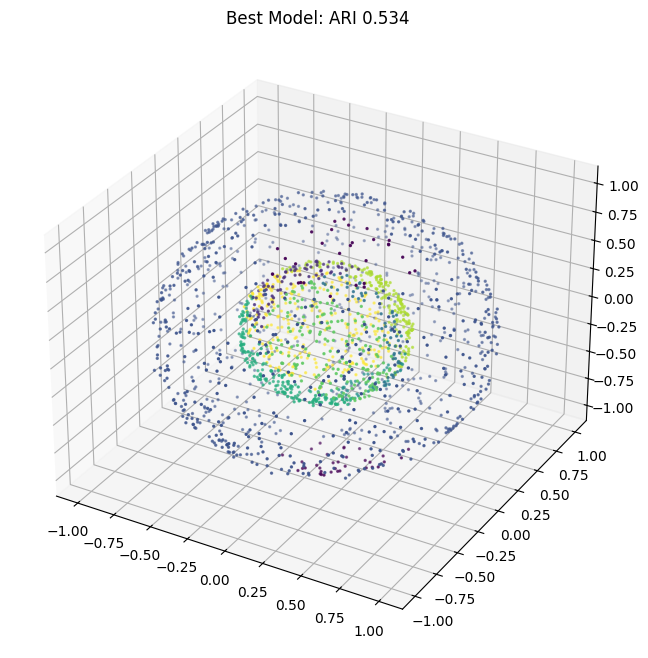

In [26]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

# Hard Cocentric Spheres

## Base

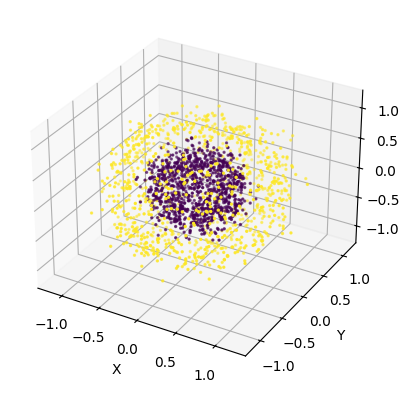

In [78]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.1 # Standard deviation for the radii
seed_dataset = 42
features, true_labels = generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000, seed=seed_dataset)

visualize_3d_data(features, true_labels)

features_extended = np.hstack((features,np.sum(features**2, axis=1, keepdims=True)))

In [79]:
random_state_model = 42

# pseudo kernel kmeans parameters
n_clusters = 2
gamma = 2
n_rff = 500
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters, 'random_state': random_state_model}
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}
pseudo_kernel_kmeans = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
pseudo_kernel_kmeans_labels = pseudo_kernel_kmeans.fit_predict(features_extended)
ari_pseudo_kernel_kmeans = adjusted_rand_score(true_labels, pseudo_kernel_kmeans_labels)

# kernel kmeans parameters
gamma = 2
n_clusters = 2
kernel = 'rbf'
kernel_kmeans = KernelKMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma, random_state=random_state_model)
kernel_kmeans_labels = kernel_kmeans.fit_predict(features_extended)
ari_kernel_kmeans = adjusted_rand_score(true_labels, kernel_kmeans_labels)

# kernel cohirf parameters
random_state_model = 13
n_features = 2
repetitions = 3
n_clusters = 2
representative_method = 'rbf'
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters}
gamma = 3
n_rff = 500
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}
cohirf_kernel = ModularCoHiRF(n_features=n_features, repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        transform_method=transform_method, transform_kwargs=transform_kwargs, random_state=random_state_model, sample_than_transform=True)
cohirf_kernel_labels = cohirf_kernel.fit_predict(features_extended)
ari_cohirf_kernel = adjusted_rand_score(true_labels, cohirf_kernel_labels)

In [80]:
# HDBSCAN parameters
min_cluster_size = 20
hdbscan = HDBSCAN(min_cluster_size=min_cluster_size)
hdbscan_labels = hdbscan.fit_predict(features_extended)
ari_hdbscan = adjusted_rand_score(true_labels, hdbscan_labels)

In [81]:
# DBSCAN parameters
eps = 1
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(features_extended)
ari_dbscan = adjusted_rand_score(true_labels, dbscan_labels)


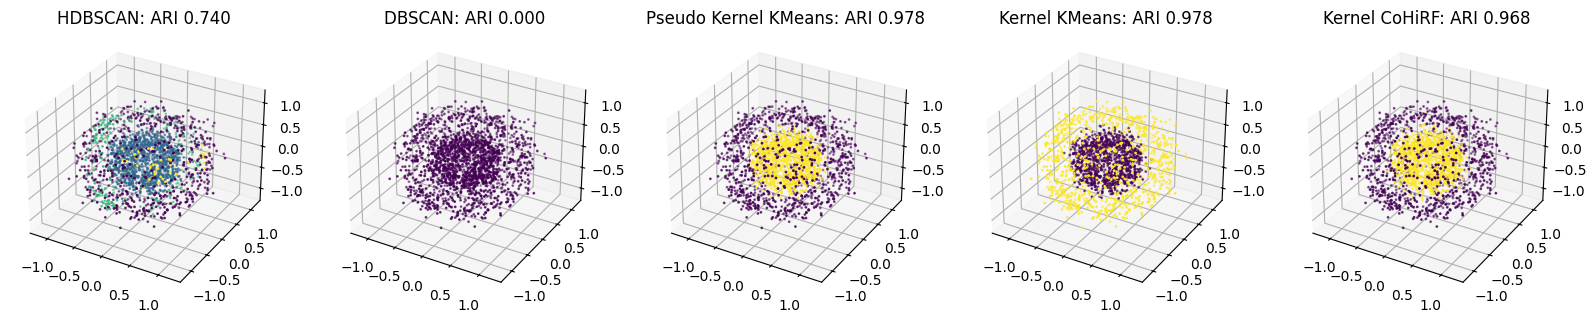

In [82]:
labels_list = [hdbscan_labels, dbscan_labels, pseudo_kernel_kmeans_labels, kernel_kmeans_labels, cohirf_kernel_labels]
ari_list = [ari_hdbscan, ari_dbscan, ari_pseudo_kernel_kmeans, ari_kernel_kmeans, ari_cohirf_kernel]
labels_names = ['HDBSCAN', 'DBSCAN', 'Pseudo Kernel KMeans', 'Kernel KMeans', 'Kernel CoHiRF']

n_figs = len(labels_list)

fig, axs = plt.subplots(1, n_figs, figsize=(4*n_figs, 4), subplot_kw={'projection': '3d'})

for i, (label, ari, name) in enumerate(zip(labels_list, ari_list, labels_names)):
    axs[i].scatter(features[:, 0], features[:, 1], features[:, 2], c=label, cmap='viridis', s=1)
    axs[i].set_title(f'{name}: ARI {ari:.3f}')
    i += 1
plt.show()

## KPCA HDBSCAN

In [83]:
kernel = 'rbf'
gamma = 2
n_components = 3
random_state_model = 42
base_model = HDBSCAN
base_model_kwargs = {'min_cluster_size': 5}
transform_method = KernelPCA
transform_kwargs = dict(kernel=kernel, n_components=n_components, gamma=gamma)
model = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
labels = model.fit_predict(features_extended)
ari = adjusted_rand_score(true_labels, labels)

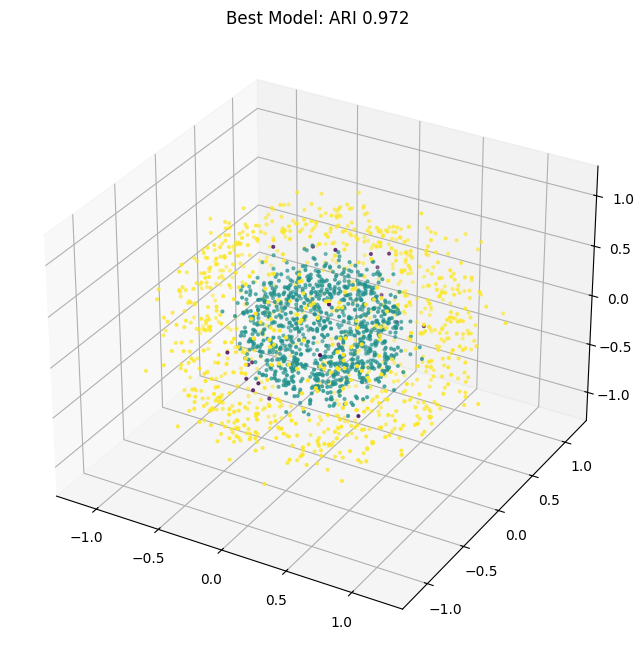

In [84]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=4)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

## Optimization Approx Kernel Kmeans

In [85]:
random_state_model = 42000
model_cls = PseudoKernelClustering
search_space = {
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2 ,'random_state': random_state_model},
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500, 'random_state': random_state_model},
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 11:01:17,808] A new study created in memory with name: no-name-b1ebb376-ebff-4324-b564-640399d85b07


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

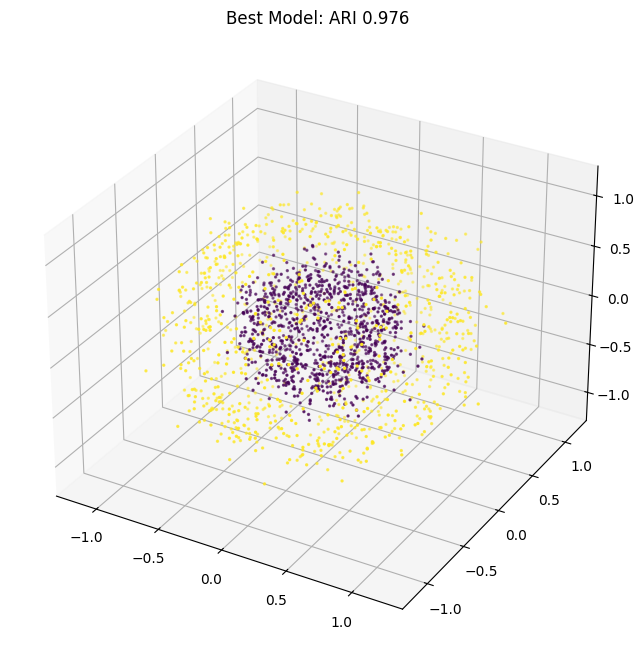

In [86]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

## Optimization Kernel Cohirf

In [87]:
random_state_model = 13
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'n_features': 2,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2},
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=50, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 11:01:21,751] A new study created in memory with name: no-name-a8e7c644-23dd-4e45-9ecd-75c37b8cd4e4


Trials:   0%|          | 0/50 [00:00<?, ?it/s]

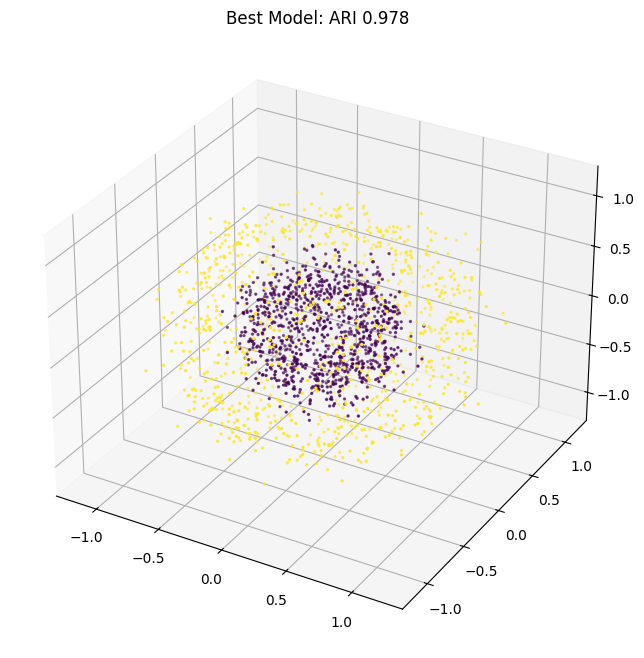

In [88]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

In [89]:
best_params

{'repetitions': 3,
 'transform_kwargs': {'gamma': 4.645312842796526, 'n_components': 500},
 'n_features': 2,
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'base_model_kwargs': {'n_clusters': 2},
 'transform_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 13,
 'sample_than_transform': True}

# More samples -> work in progress

In [9]:
n_samples = int(1e8)
n_features = 2
centers = 2
cluster_std = 1
random_state = 42
X, true_labels = dask_make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random_state,
    chunks=int(1e6),
)

In [10]:
random_state_model = 42000
kmeans = LazyMiniBatchKMeans(n_clusters=centers, batch_size=int(1e6), random_state=random_state_model)
kmeans_labels = kmeans.fit_predict(X)

In [13]:
kmeans_labels = da.from_array(kmeans_labels, chunks=true_labels.chunksize)
ari_kmeans = dask_adjusted_rand_score(true_labels, kmeans_labels)
print(f"ARI KMeans: {ari_kmeans:.3f}")

ARI KMeans: 1.000


In [14]:
random_state_model = 42000
cohirf = ModularCoHiRF(
    repetitions=3,
    n_features=1,
    representative_method="closest_overall",
    random_state=random_state_model,
    base_model=KMeans,
    base_model_kwargs={"n_clusters": centers},
    sample_than_transform=True,
    batch_size=int(1e6),
)
cohirf_labels = cohirf.fit_predict(X)

: 